In [6]:
DATASET_PATH = '../data/raw/data_carrers.csv'
OUTPUT_PATH = '../data/processed/processed-dataset.csv'
import pandas as pd
import numpy as np
import torch
import random
import re
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, AdamW, get_cosine_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import matplotlib.pyplot as plt
import re


# Cargar el dataset
df = pd.read_csv(DATASET_PATH, encoding="UTF-8")

# Eliminar valores nulos y duplicados
df = df.dropna()
df = df.drop_duplicates()
# Preprocesar el texto
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\sáéíóúñü]', '', text)  # Elimina caracteres especiales pero mantiene caracteres acentuados
    text = re.sub(r'\s+', ' ', text)  # Reemplaza múltiples espacios por uno solo
    text = text.strip()  # Elimina espacios en blanco al inicio y al final
    return text

df['TEXTO'] = df['TEXTO'].apply(preprocess_text)

# Mapear las categorías a índices numéricos
print(df['CARRERA'].unique())
categories = df['CARRERA'].unique().tolist()
category_to_index = {category: idx for idx, category in enumerate(categories)}
df['LABEL'] = df['CARRERA'].map(category_to_index)

texts = df['TEXTO'].tolist()
labels = df['LABEL'].tolist()

print(labels)


['INDUSTRIAL' 'CIVIL' 'INFORMÁTICA' 'TELECOMUNICACIONES' 'ARQUITECTURA'
 'FILOSOFÍA' 'PSICOLOGÍA' 'LETRAS' 'COMUNICACIÓN SOCIAL' 'EDUCACIÓN'
 'ADMINISTRACIÓN' 'CONTADURÍA' 'RELACIONES INDUSTRIALES' 'SOCIOLOGÍA'
 'ECONOMÍA' 'DERECHO' 'TEOLOGÍA']
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 

In [7]:


tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']
labels = torch.tensor(labels)

dataset = TensorDataset(input_ids, attention_mask, labels)


c:\Users\aleja\Desktop\Tesis\ML-Vocational-Interest-Project\venv\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\aleja\.cache\huggingface\hub\models--dccuchile--bert-base-spanish-wwm-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [8]:

# Convertir tensores a numpy arrays
input_ids_np = input_ids.numpy()
attention_mask_np = attention_mask.numpy()
labels_np = labels.numpy()

# División en entrenamiento+validación y prueba
X_train_val, X_test, y_train_val, y_test, mask_train_val, mask_test = train_test_split(
    input_ids_np, labels_np, attention_mask_np, test_size=0.2, random_state=42, stratify=labels_np)

# División en entrenamiento y validación
X_train, X_val, y_train, y_val, mask_train, mask_val = train_test_split(
    X_train_val, y_train_val, mask_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

print(y_train, y_val.shape, y_test.shape)
# Convertir a tensores
train_dataset = TensorDataset(torch.tensor(X_train,dtype=torch.long), torch.tensor(mask_train,dtype=torch.long), torch.tensor(y_train,dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val,dtype=torch.long), torch.tensor(mask_val,dtype=torch.long), torch.tensor(y_val,dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.long), torch.tensor(mask_test, dtype=torch.long), torch.tensor(y_test, dtype=torch.long))

# Crear DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)


config = BertConfig.from_pretrained('dccuchile/bert-base-spanish-wwm-cased', 
                                    num_labels=len(category_to_index), 
                                    hidden_dropout_prob=0.3, 
                                    attention_probs_dropout_prob=0.3)

model = BertForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-cased', config=config)

optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)

# Suponiendo que 'y_train' contiene las etiquetas de entrenamiento
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


[ 4 15 14  1 16 11 15  8  5  6 15  2 12 15  3  9 10 15  7  9 15 12  4 16
  1  1  9 10  1  6  4  4  4 16 15  2  1  6  7  0  7  4 11  7 14  3  1  6
  4  8 13 15  5 15  5 12 11  6 10  3 14  6 13  5  1  4 15  1 12 11 14  9
  2  1  7  9  4 12 16 15  9  1 15 10  2 16  5  1  0 11  7  3  2 14 11 10
 10 12  6  4  1  6  6  7  4 15  0 12  7  2  9  1 12  9  7  5 10  7  1 15
  5  7  5  1 15 13 10 12  2 11  7 13 15 10  4 13  1  6  8  3 16  5  7  6
  0 16 10 14 10  4  4 11  9 16  7 12  8  6 14  5 16  6 16 14  6  1 16  4
  5 11  3  5  0 10 13 10  0  1  0  5  9  8 10 14  2 11  6  8 15 10  0  2
 14  6  9 15  1  8  5  2 15  6  4 14 16  0  4  2  8  8 16  0 12  5 10 10
  5 16  6  1  6  9  8  1  0  2 11  2 13  1  5  9  8  7  0 15  0 13  2  7
  4 10  5 10  8  4 10  3  0  1  4  9  0 12 12  2  3  2  3  9 15 14 14 12
  2  9  2  2 16  9 11  9 14 12 16 16  1  6  6 16  4 10  2  4  6  3 12  6
 12  4  5  2 13 14  4 12  8  0  0  3 12 11  3  0  5  5  9  5  9  8  4 14
 10 15  8  2  1  3  8  3  8  7  4  3 11  4  8  3 12

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\aleja\Desktop\Tesis\ML-Vocational-Interest-Project\venv\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [9]:
## BUCLE DE ENTRENAMIENTO

epochs = 20
total_steps = len(train_dataloader) * epochs
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
# Configurar el modelo en modo de entrenamiento




device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Después de calcular class_weights
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

loss_fn = CrossEntropyLoss(weight=class_weights)
model.to(device)
model.train()

training_losses = []
validation_losses = []
validation_accuracies = []
training_accuracies = []
training_f1_scores = []
validation_f1_scores = []  # Agrega esta línea aquí

for epoch in range(epochs):
    ### Entrenamiento ###
    model.train()
    total_train_loss = 0
    train_predictions = []
    train_true_labels = []

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} - Entrenamiento"):
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
                # Almacenar predicciones y etiquetas
        preds = torch.argmax(logits, dim=1)
        train_predictions.extend(preds.cpu().numpy())
        train_true_labels.extend(labels.cpu().numpy())
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_losses.append(avg_train_loss)
    
    # Calcular métricas de entrenamiento
    train_accuracy = accuracy_score(train_true_labels, train_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
    train_true_labels, train_predictions, average='weighted')
    training_accuracies.append(train_accuracy)
    training_f1_scores.append(f1)


    ### Validación ###
    model.eval()
    total_val_loss = 0
    val_predictions = []
    val_true_labels = []

    with torch.no_grad():
        for batch in tqdm(validation_dataloader, desc=f"Epoch {epoch+1}/{epochs} - Validación"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            total_val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_predictions.extend(preds.cpu().numpy())
            val_true_labels.extend(labels.cpu().numpy())
    
    avg_val_loss = total_val_loss / len(validation_dataloader)
    validation_losses.append(avg_val_loss)

    # Calcular precisión en validación
    val_accuracy = accuracy_score(val_true_labels, val_predictions)
    validation_accuracies.append(val_accuracy)
    
    # Después de calcular avg_val_loss y val_accuracy, agrega:
    precision, recall, f1, _ = precision_recall_fscore_support(
        val_true_labels, val_predictions, average='weighted')
    validation_f1_scores.append(f1)
    


    print(f"Epoch {epoch+1}/{epochs}, Pérdida Entrenamiento: {avg_train_loss:.4f}, Pérdida Validación: {avg_val_loss:.4f}, Precisión Validación: {val_accuracy:.4f}")
    
    # Definir variables para Early Stopping
    if epoch == 0:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model_state.bin')
    else:
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model_state.bin')

Epoch 1/20 - Validación: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]
c:\Users\aleja\Desktop\Tesis\ML-Vocational-Interest-Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20, Pérdida Entrenamiento: 2.8449, Pérdida Validación: 2.8411, Precisión Validación: 0.0509


Epoch 2/20 - Validación: 100%|██████████| 7/7 [00:06<00:00,  1.15it/s]
c:\Users\aleja\Desktop\Tesis\ML-Vocational-Interest-Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/20, Pérdida Entrenamiento: 2.8333, Pérdida Validación: 2.8013, Precisión Validación: 0.0926


Epoch 3/20 - Validación: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]
c:\Users\aleja\Desktop\Tesis\ML-Vocational-Interest-Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/20, Pérdida Entrenamiento: 2.7896, Pérdida Validación: 2.6772, Precisión Validación: 0.2731


Epoch 4/20 - Validación: 100%|██████████| 7/7 [00:05<00:00,  1.28it/s]


Epoch 4/20, Pérdida Entrenamiento: 2.5969, Pérdida Validación: 2.1699, Precisión Validación: 0.6111


Epoch 5/20 - Validación: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


Epoch 5/20, Pérdida Entrenamiento: 2.1440, Pérdida Validación: 1.4931, Precisión Validación: 0.7454


Epoch 6/20 - Validación: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]


Epoch 6/20, Pérdida Entrenamiento: 1.5519, Pérdida Validación: 1.0227, Precisión Validación: 0.8287


Epoch 7/20 - Validación: 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]


Epoch 7/20, Pérdida Entrenamiento: 1.1358, Pérdida Validación: 0.7319, Precisión Validación: 0.8565


Epoch 8/20 - Validación: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


Epoch 8/20, Pérdida Entrenamiento: 0.8248, Pérdida Validación: 0.5661, Precisión Validación: 0.8796


Epoch 9/20 - Validación: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]


Epoch 9/20, Pérdida Entrenamiento: 0.6462, Pérdida Validación: 0.4937, Precisión Validación: 0.8843


Epoch 10/20 - Validación: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


Epoch 10/20, Pérdida Entrenamiento: 0.5227, Pérdida Validación: 0.4567, Precisión Validación: 0.8657


Epoch 11/20 - Validación: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


Epoch 11/20, Pérdida Entrenamiento: 0.4466, Pérdida Validación: 0.4118, Precisión Validación: 0.8750


Epoch 12/20 - Validación: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


Epoch 12/20, Pérdida Entrenamiento: 0.3880, Pérdida Validación: 0.3980, Precisión Validación: 0.8843


Epoch 13/20 - Validación: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


Epoch 13/20, Pérdida Entrenamiento: 0.3321, Pérdida Validación: 0.4055, Precisión Validación: 0.8843


Epoch 14/20 - Validación: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


Epoch 14/20, Pérdida Entrenamiento: 0.3159, Pérdida Validación: 0.3927, Precisión Validación: 0.8750


Epoch 15/20 - Validación: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]


Epoch 15/20, Pérdida Entrenamiento: 0.2908, Pérdida Validación: 0.4021, Precisión Validación: 0.8889


Epoch 16/20 - Validación: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]


Epoch 16/20, Pérdida Entrenamiento: 0.2523, Pérdida Validación: 0.3843, Precisión Validación: 0.8981


Epoch 17/20 - Validación: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


Epoch 17/20, Pérdida Entrenamiento: 0.2442, Pérdida Validación: 0.3780, Precisión Validación: 0.8889


Epoch 18/20 - Validación: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


Epoch 18/20, Pérdida Entrenamiento: 0.2548, Pérdida Validación: 0.3808, Precisión Validación: 0.8935


Epoch 19/20 - Validación: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


Epoch 19/20, Pérdida Entrenamiento: 0.2356, Pérdida Validación: 0.3805, Precisión Validación: 0.8935


Epoch 20/20 - Validación: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]

Epoch 20/20, Pérdida Entrenamiento: 0.2486, Pérdida Validación: 0.3805, Precisión Validación: 0.8935


C:\Users\aleja\AppData\Local\Temp\ipykernel_18828\1688832001.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_state.bin'))
Ev

                         precision    recall  f1-score   support

             INDUSTRIAL       0.73      0.73      0.73        15
                  CIVIL       0.86      0.92      0.89        13
            INFORMÁTICA       0.92      0.86      0.89        14
     TELECOMUNICACIONES       1.00      0.86      0.92        14
           ARQUITECTURA       0.92      0.85      0.88        13
              FILOSOFÍA       0.82      0.75      0.78        12
             PSICOLOGÍA       0.75      0.92      0.83        13
                 LETRAS       0.92      0.92      0.92        12
    COMUNICACIÓN SOCIAL       0.85      0.92      0.88        12
              EDUCACIÓN       1.00      0.92      0.96        12
         ADMINISTRACIÓN       0.69      0.75      0.72        12
             CONTADURÍA       0.83      0.83      0.83        12
RELACIONES INDUSTRIALES       0.92      1.00      0.96        12
             SOCIOLOGÍA       1.00      0.85      0.92        13
               ECONOMÍA 

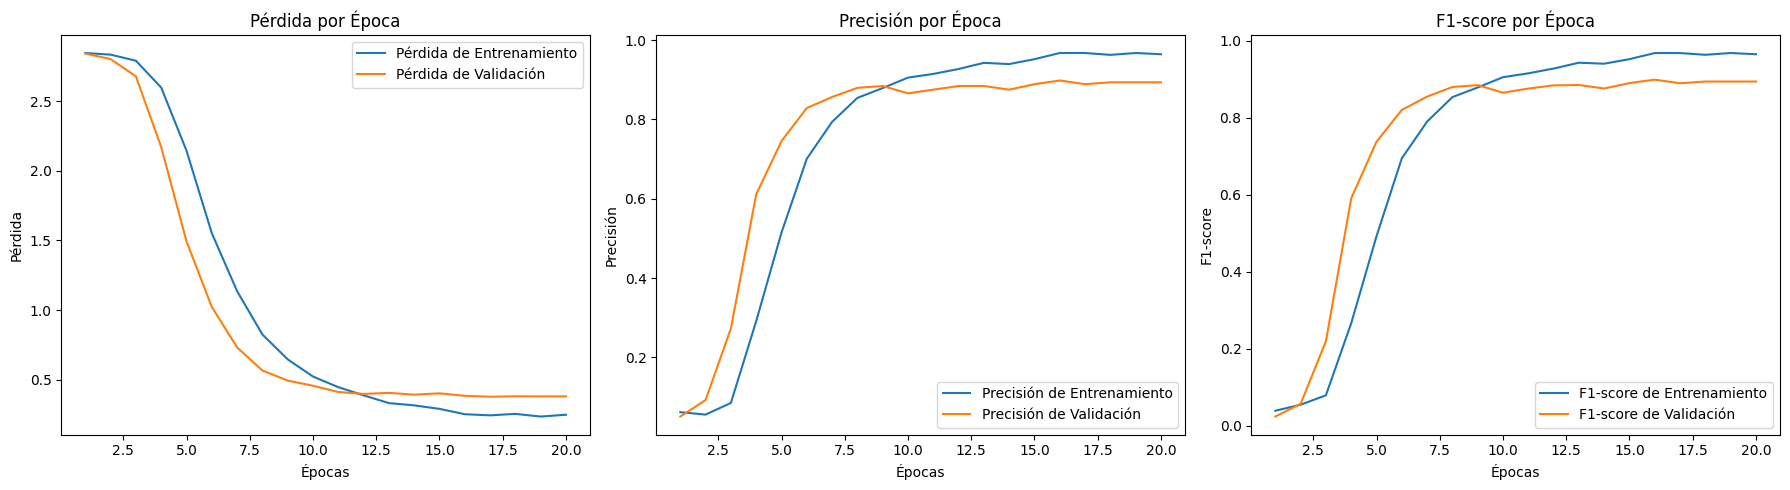

In [10]:
# Cargar el mejor modelo
model.load_state_dict(torch.load('best_model_state.bin'))

model.eval()
test_predictions = []
test_true_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluación en Conjunto de Prueba"):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        test_predictions.extend(preds.cpu().numpy())
        test_true_labels.extend(labels.cpu().numpy())

# Generar el reporte de clasificación
from sklearn.metrics import classification_report

print(classification_report(test_true_labels, test_predictions, target_names=categories))
## MONITOREO DE GRÁFICOS Y METRICAS


epochs_range = range(1, len(training_losses) + 1)

plt.figure(figsize=(18, 5))

# Gráfica de pérdidas
plt.subplot(1, 3, 1)
plt.plot(epochs_range, training_losses, label='Pérdida de Entrenamiento')
plt.plot(epochs_range, validation_losses, label='Pérdida de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida por Época')

# Gráfica de precisión
plt.subplot(1, 3, 2)
plt.plot(epochs_range, training_accuracies, label='Precisión de Entrenamiento')
plt.plot(epochs_range, validation_accuracies, label='Precisión de Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Precisión por Época')

# Gráfica de F1-score
plt.subplot(1, 3, 3)
plt.plot(epochs_range, training_f1_scores, label='F1-score de Entrenamiento')
plt.plot(epochs_range, validation_f1_scores, label='F1-score de Validación')
plt.xlabel('Épocas')
plt.ylabel('F1-score')
plt.legend()
plt.title('F1-score por Época')

plt.tight_layout()
plt.show()
